<a href="https://colab.research.google.com/github/m3yrin/seccon2019_ws_detection/blob/master/seccon_ws_detection_m3yrin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN model for 攻撃自動検知ワークショップ in SECCON 2019 

https://connpass.com/event/159753/  
seccon_ws_detection  

auther : ＠m3yrin

## Model Specification
* Char-Base CNN sequence modeling

## Memo
* Bulit on AllenNLP
* Tested on Google Colaboratory

## Preparation

In [1]:
!git clone https://github.com/palloc/seccon_ws_detection.git
!pip install allennlp

Cloning into 'seccon_ws_detection'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 1), reused 17 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.
     |████████████████████████████████| 7.6MB 7.9MB/s 
     |████████████████████████████████| 163kB 51.2MB/s 
     |████████████████████████████████| 256kB 31.0MB/s 
     |████████████████████████████████| 194kB 47.7MB/s 
     |████████████████████████████████| 245kB 44.7MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
     |████████████████████████████████| 133kB 48.1MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 1.0MB 22.5MB/s 
  Created wheel for jsonnet: filename=jsonnet-0.14.0-cp36-cp36m-linux_x86_64.whl size=3320370 sha256=cfe61f7c41c9c2bf3e1f26a97f152970ec850434f57905d0c78bc7cdf7a6739c
  Stored in directory: /root/.cache/pip/wheels/5b/b7/83/985f0

In [2]:
%cd seccon_ws_detection

/content/seccon_ws_detection


In [3]:
!wget -P dataset https://raw.githubusercontent.com/palloc/seccon_ws_detection/score/dataset/level2_train.tsv

--2019-12-22 15:54:49--  https://raw.githubusercontent.com/palloc/seccon_ws_detection/score/dataset/level2_train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12683 (12K) [text/plain]
Saving to: ‘dataset/level2_train.tsv’

level2_train.tsv    100%[===================>]  12.39K  --.-KB/s    in 0s      

2019-12-22 15:54:49 (153 MB/s) - ‘dataset/level2_train.tsv’ saved [12683/12683]



In [4]:
!ls

dataset  score.py  simple_classifier.py


In [0]:
# filepath configs
import os

full_path = './'
DATA_DIR = os.path.join(full_path, 'dataset')

#ORIGINAL_FILE = 'level1_train.tsv'
ORIGINAL_FILE = 'level2_train.tsv'
ORIGINAL_PATH = os.path.join(DATA_DIR, ORIGINAL_FILE)

TRAIN_FILE = 'level2_split_train.tsv'
TRAIN_PATH = os.path.join(DATA_DIR, TRAIN_FILE)

VALID_FILE = 'level2_split_valid.tsv'
VALID_PATH = os.path.join(DATA_DIR, VALID_FILE)

AUG_FILE = 'train_aug.tsv'
AUG_PATH = os.path.join(DATA_DIR, AUG_FILE)

# for random seed.
random_state = 32

## EDA

In [0]:
import codecs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(seed=random_state)

In [0]:
# Load dataset.
def load_dataset(path, num_augment = None):
    dataset = []
    X = []
    y = []
    with codecs.open(path, mode='r', encoding='utf-8') as fin:
        dataset.extend(fin.readlines())
    
    for payload in dataset:
        X.append(payload.split('\t')[0])

        label = payload.split('\t')[1].replace('\n', '')
        label = int(label)
        y.append(label)

    # Data augmentation
    # sampling random 2 indices and concatinating them.
    if num_augment is not None:
        X_aug = []
        y_aug = []

        ids_list = np.random.randint(len(X), size=(num_augment, 2))

        for ids in ids_list:
            X_concat = X[ids[0]] + X[ids[1]]

            y_concat = 1 if y[ids[0]] + y[ids[1]] > 0 else 0

            X_aug.append(X_concat)
            y_aug.append(y_concat)
        
        # Also added original sequences
        return  X_aug + X, y_aug + y

    return X, y

In [0]:
X, y = load_dataset(ORIGINAL_PATH)
data_df = pd.DataFrame(zip(X, y))
data_df.columns = ['X','y']

In [9]:
data_df.head()

,X,y
0,From: lipman@oasys.dt.navy.mil (Robert Lipman),0
1,Subject: CALL FOR PRESENTATIONS: Navy SciViz/V...,0
2,SPONSOR: NESS (Navy Engineering Software Syste...,0
3,This computer is occurred a error on the memory.,0
4,The purpose of the seminar is to present and e...,0


In [10]:
data_df.describe()

,y
count,200.000000
mean,0.500000
std,0.501255
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


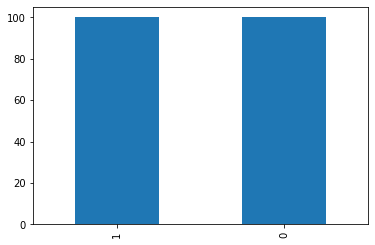

In [11]:
# check the distribution of y
data_df.y.value_counts().plot(kind="bar")
plt.show()

## File Split

In [0]:
test_size = 0.2

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [0]:
train_df = pd.DataFrame(zip(train_X, train_y))
valid_df = pd.DataFrame(zip(valid_X, valid_y))

In [0]:
train_df.to_csv(TRAIN_PATH, sep='\t', index=False, header=False)
valid_df.to_csv(VALID_PATH, sep='\t', index=False, header=False)

## Data Augmentation

In [0]:
num_augment = 400

In [18]:
X, y = load_dataset(TRAIN_PATH, num_augment = num_augment)

data_auged_df = pd.DataFrame(zip(X, y))
data_auged_df.columns = ['X','y']
data_auged_df.head()

,X,y
0,Added lines are prepended with a `+'The frame ...,0
1,"""""""</table><video><source onerror=jAvaScrIpt:w...",1
2,<svg/onload=alert(1); </del>&#x09;rel=<video><...,1
3,"good service, too. But if you think all local ...",1
4,javascript:\u0061lert();</script><frameset><ba...,1


In [19]:
data_auged_df.describe()

,y
count,560.000000
mean,0.685714
std,0.464646
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


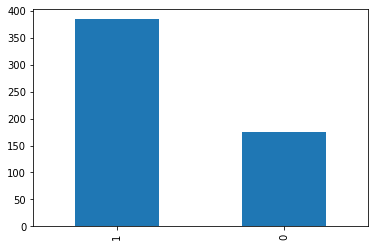

In [20]:
data_auged_df.y.value_counts().plot(kind="bar")
plt.show()

In [0]:
data_auged_df.to_csv(AUG_PATH, sep='\t' , index = False, header=False)

In [22]:
!ls dataset

level1_test.tsv   level2_split_train.tsv  level2_train.tsv
level1_train.tsv  level2_split_valid.tsv  train_aug.tsv


## Modeling

In [0]:
# Parameters

## for model
char_min_count = 1
batch_size = 32
hidden_dim = 64
dropout_prob = 0.2

## for training
LR = 1e-4
PATIENCE = 50
EPOCHS = 100

In [0]:
import os
import codecs

import numpy as np
import pandas as pd
import logging

import itertools
import json
import logging
import string
from collections import defaultdict
from typing import Dict, List, Union, Tuple, Any, Optional

from overrides import overrides
from word2number.w2n import word_to_num

import torch

import allennlp
from allennlp.common.file_utils import cached_path
from allennlp.data.fields import (
    Field,
    TextField,
    MetadataField,
    LabelField,
    ListField,
    SequenceLabelField,
    SpanField,
    IndexField,
)

from allennlp.data.dataset_readers.dataset_reader import DatasetReader
from allennlp.data.instance import Instance
from allennlp.data.tokenizers import Token, Tokenizer
from allennlp.data.token_indexers.token_indexer import TokenIndexer

In [0]:
# logging setting
logging.basicConfig(format='%(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [0]:
class Lv1Reader(DatasetReader):

    def __init__(
        self,
        tokenizer: Tokenizer = None,
        token_indexers: Dict[str, TokenIndexer] = None,
        lazy: bool = False,
    ) -> None:
        super().__init__(lazy)
        self._tokenizer = tokenizer or WhitespaceTokenizer()
        self._token_indexers = token_indexers

    @overrides
    def _read(self, file_path: str):
        file_path = cached_path(file_path)
        
        with codecs.open(file_path, mode='r', encoding='utf-8') as dataset_file:
            for line in dataset_file:
                
                example = line.split('\t')
                payload = example[0]
                payload = self._tokenizer.tokenize(payload)

                target = None
                if len(example) == 2:
                    target = example[1].replace('\n', '')
                    target = int(target)
                
                instance = self.text_to_instance(
                    payload,
                    target,
                )
                yield instance
                

    @overrides
    def text_to_instance(
        self,  # type: ignore
        payload: str,
        target: int,
        ) -> Union[Instance, None]:
        
        fields: Dict[str, Field] = {}
        fields["payload"] = TextField(payload, self._token_indexers)

        if target is not None:
            fields["target"] = LabelField(target, skip_indexing=True)
        
        return Instance(fields)

In [27]:
from allennlp.data.tokenizers.character_tokenizer import CharacterTokenizer
from allennlp.data.token_indexers.token_characters_indexer import TokenCharactersIndexer
from allennlp.data.token_indexers.single_id_token_indexer import SingleIdTokenIndexer


reader = Lv1Reader(tokenizer = CharacterTokenizer(),
                   token_indexers = {"tokens": SingleIdTokenIndexer(lowercase_tokens = True)}
                  )

train_dataset = reader.read(AUG_PATH)
valid_dataset = reader.read(VALID_PATH)

560it [00:00, 3333.74it/s]
40it [00:00, 5587.75it/s]


In [28]:
from allennlp.data.vocabulary import Vocabulary
vocab = Vocabulary.from_instances(train_dataset, min_count={'tokens': char_min_count})
vocab

Fitting token dictionary from dataset.
100%|██████████| 560/560 [00:00<00:00, 12657.21it/s]


Vocabulary with namespaces:  tokens, Size: 70 || Non Padded Namespaces: {'*tags', '*labels'}

In [0]:
from allennlp.data.iterators import BasicIterator, BucketIterator

iterator = BucketIterator(
    batch_size=batch_size,
    sorting_keys=[("payload", "num_tokens")],
)
iterator.index_with(vocab)

In [0]:
from allennlp.modules.token_embedders import Embedding
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder

embedding = Embedding(num_embeddings=vocab.get_vocab_size(), embedding_dim=hidden_dim, padding_index=0)
embedder = BasicTextFieldEmbedder({"tokens": embedding})

In [31]:
from allennlp.nn.util import get_text_field_mask

from allennlp.models.model import Model
from allennlp.modules import FeedForward, Seq2SeqEncoder, Seq2VecEncoder, TextFieldEmbedder
from allennlp.nn import InitializerApplicator, RegularizerApplicator
from allennlp.training.metrics import CategoricalAccuracy
from allennlp.training.metrics.auc import Auc

class Lv1Net(Model):

    def __init__(
        self,
        vocab: Vocabulary,
        text_field_embedder: TextFieldEmbedder,
        seq2vec_encoder: Seq2VecEncoder,
        num_labels: int,
        feedforward: Optional[FeedForward] = None,
        dropout_prob: float = 0.1,
        initializer: InitializerApplicator = InitializerApplicator(),
        regularizer: Optional[RegularizerApplicator] = None,
    ) -> None:
        super().__init__(vocab, regularizer)

        self._text_field_embedder = text_field_embedder
        text_embed_dim = text_field_embedder.get_output_dim()
        self._dropout = torch.nn.Dropout(p=dropout_prob)

        self._seq2vec_encoder = seq2vec_encoder
        self._feedforward = feedforward
        self._num_labels = num_labels
        
        if feedforward is not None:
            self._classifier_input_dim = self._feedforward.get_output_dim()
        else:
            self._classifier_input_dim = self._seq2vec_encoder.get_output_dim()

        self._classification_layer = torch.nn.Linear(self._classifier_input_dim, self._num_labels)

        self._accuracy = CategoricalAccuracy()
        self._auc = Auc(positive_label = 1)
        self._loss = torch.nn.CrossEntropyLoss()
        initializer(self)
        

    def forward(  # type: ignore
        self,
        payload: Dict[str, torch.LongTensor],
        target: torch.IntTensor = None,
    ) -> Dict[str, torch.Tensor]:

        
        mask = get_text_field_mask(payload).float()


        # Shape: (batch_size, payload_length, hidden)
        embedded_text = self._text_field_embedder(payload)
        embedded_text = self._seq2vec_encoder(embedded_text, mask=mask)

        embedded_text = self._dropout(embedded_text)

        if self._feedforward is not None:
            embedded_text = self._feedforward(embedded_text)

        logits = self._classification_layer(embedded_text)
        probs = torch.nn.functional.softmax(logits, dim=-1)

        output_dict = {"logits": logits, "probs": probs}

        if target is not None:
            loss = self._loss(logits, target.long().view(-1))
            output_dict["loss"] = loss
            self._accuracy(logits, target)
            self._auc(logits.argmax(dim=1), target)
        
        return output_dict

    @overrides
    def decode(self, output_dict: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """
        Does a simple argmax over the probabilities, converts index to string label, and
        add ``"label"`` key to the dictionary with the result.
        """
        predictions = output_dict["probs"]
        if predictions.dim() == 2:
            predictions_list = [predictions[i] for i in range(predictions.shape[0])]
        else:
            predictions_list = [predictions]
        classes = []
        for prediction in predictions_list:
            label_idx = prediction.argmax(dim=-1).item()
            label_str = str(label_idx)
            classes.append(label_str)
        output_dict["label"] = classes
        return output_dict

    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        metrics = {"accuracy": self._accuracy.get_metric(reset), "auc": self._auc.get_metric(reset)}
        return metrics

instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>


In [32]:
from allennlp.modules.seq2vec_encoders.cnn_encoder import CnnEncoder
encoder = CnnEncoder(embedding_dim = hidden_dim, num_filters = hidden_dim)

instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>


In [33]:
model = Lv1Net(vocab = vocab,
               text_field_embedder = embedder,
               seq2vec_encoder = encoder,
               num_labels = 2,
               dropout_prob = dropout_prob
               )

Initializing parameters
Done initializing parameters; the following parameters are using their default initialization from their code
   _classification_layer.bias
   _classification_layer.weight
   _seq2vec_encoder.conv_layer_0.bias
   _seq2vec_encoder.conv_layer_0.weight
   _seq2vec_encoder.conv_layer_1.bias
   _seq2vec_encoder.conv_layer_1.weight
   _seq2vec_encoder.conv_layer_2.bias
   _seq2vec_encoder.conv_layer_2.weight
   _seq2vec_encoder.conv_layer_3.bias
   _seq2vec_encoder.conv_layer_3.weight
   _text_field_embedder.token_embedder_tokens.weight


In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=LR)

In [35]:
if torch.cuda.is_available():
    print("cuda")
    cuda_device = 0
    model = model.cuda(cuda_device)
else:
    print("cpu")
    cuda_device = -1

cuda


In [0]:
from allennlp.training.trainer import Trainer

trainer = Trainer(model = model,
                  optimizer = optimizer,
                  iterator = iterator,
                  train_dataset = train_dataset,
                  validation_dataset = valid_dataset,
                  patience = PATIENCE,
                  validation_metric = "+auc",
                  #validation_metric = "+accuracy",
                  num_epochs = EPOCHS,
                  cuda_device = cuda_device
                 )

In [37]:
trainer.train()

Beginning training.
Epoch 0/99
Peak CPU memory usage MB: 2600.444
GPU 0 memory usage MB: 719
Training
accuracy: 0.6821, auc: 0.5020, loss: 0.6587 ||: 100%|██████████| 18/18 [00:00<00:00, 24.73it/s]
Validating
accuracy: 0.5500, auc: 0.5000, loss: 0.6810 ||: 100%|██████████| 2/2 [00:00<00:00, 124.77it/s]
                    Training |  Validation
accuracy        |     0.682  |     0.550
loss            |     0.659  |     0.681
cpu_memory_MB   |  2600.444  |       N/A
gpu_0_memory_MB |   719.000  |       N/A
auc             |     0.502  |     0.500
Epoch duration: 0:00:00.828010
Estimated training time remaining: 0:01:22
Epoch 1/99
Peak CPU memory usage MB: 2619.216
GPU 0 memory usage MB: 773
Training
accuracy: 0.6857, auc: 0.5000, loss: 0.6211 ||: 100%|██████████| 18/18 [00:00<00:00, 69.38it/s]
Validating
accuracy: 0.5500, auc: 0.5000, loss: 0.6726 ||: 100%|██████████| 2/2 [00:00<00:00, 140.22it/s]
                    Training |  Validation
accuracy        |     0.686  |     0.550
loss  

{'best_epoch': 20,
 'best_validation_accuracy': 1.0,
 'best_validation_auc': 1.0,
 'best_validation_loss': 0.25908273458480835,
 'epoch': 69,
 'peak_cpu_memory_MB': 2621.296,
 'peak_gpu_0_memory_MB': 775,
 'training_accuracy': 1.0,
 'training_auc': 1.0,
 'training_cpu_memory_MB': 2621.24,
 'training_duration': '0:00:25.684968',
 'training_epochs': 69,
 'training_gpu_0_memory_MB': 775,
 'training_loss': 0.011807334971510701,
 'training_start_epoch': 0,
 'validation_accuracy': 1.0,
 'validation_auc': 1.0,
 'validation_loss': 0.026466851122677326}

## Prediction (For Lv1)

In [0]:
from allennlp.predictors.predictor import Predictor

predictor = Predictor(model, reader)

In [39]:
level1_pred = []

from tqdm import tqdm

TEST_FILE = 'level1_test.tsv'
TEST_PATH = os.path.join(DATA_DIR, TEST_FILE)
test_dataset = reader.read(TEST_PATH)

for instance in tqdm(test_dataset):
    ans = predictor.predict_instance(instance)
    level1_pred.append(ans['label'])

200it [00:00, 4849.38it/s]
100%|██████████| 200/200 [00:00<00:00, 480.77it/s]


In [40]:
level1_pred_df = pd.DataFrame(level1_pred)
level1_pred_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1,0,1,1,1,0,1,0,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,1,0,0,0,1,1,0,1,1,0,0,1,1,0,0,1,1,...,1,0,1,1,1,1,1,1,0,1,1,1,0,0,1,0,0,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,0


In [0]:
level1_pred_df.T.to_csv('level1_pred.csv', index = False, header=False)

In [0]:
from google.colab import files
files.download('level1_pred.csv')